In [3]:
!pip install --index-url https://test.pypi.org/simple/ --extra-index-url https://pypi.org/simple jihyocrypt

Looking in indexes: https://test.pypi.org/simple/, https://us-python.pkg.dev/colab-wheels/public/simple/, https://pypi.org/simple
     |████████████████████████████████| 2.3 MB 12.9 MB/s 


In [1]:
from jihyocrypt import key_maker, enc_b2b, dec_b2b, npdkf, jpic_gen, enc_f2f, dec_f2f
import timeit 
import os 
import sqlite3
import numpy as np 

In [7]:
!mkdir stests 

mkdir: cannot create directory ‘stests’: File exists


In [2]:
DB = sqlite3.connect('speed.sqlite3')
DBCursor = DB.cursor()


In [26]:

KB , MB, GB  = 1024 , 1024 * 1024 , 1024* 1024 * 1024
buffer_sizes = [150*KB, 256*KB , 512*KB, 1*MB , 2*MB, 3*MB, 5*MB, 10*MB, 50*MB, 100*MB , 256*MB , 512*MB , 1*GB, 2*GB, 4*GB]
files = {'stests/1.txt' : 150*KB , 'stests/2.txt' : MB, 'stests/3.txt' : 5*MB , 
         'stests/4.txt' : 10*MB , 'stests/5.txt' : 50*MB , 'stests/6.txt' : 100*MB } 
files2 =        {'stests/b%s.txt' % i : 100*(i+1)*MB for i in range(1,6) }
files3 =         {'stests/g1.txt' : 1*GB , 'stests/g2.txt' : 2*GB , 'stests/g4.txt' : 4*GB } 
bsizes = {100*KB , 256*KB , 512*KB, 1*MB , 2*MB , 5*MB , 10*MB, 20*MB , 50*MB , 100*MB , 200*MB , 512*MB,  1*GB , 2*GB}
files.update(files2)
files.update(files3)

In [14]:
if not os.path.isdir('stests'):
    os.makedirs('stests')

for key , value in files.items():

    if os.path.isfile(key):
        continue 

    with open(key , 'wb') as handle:
        for _ in range(value//8):
            handle.write(b'12345678')
    
    print(f'Generated:: {key}')
    

Generated:: stests/b5.txt
Generated:: stests/g1.txt
Generated:: stests/g2.txt
Generated:: stests/g4.txt


In [57]:
DBCursor.execute('begin')
DBCursor.execute('DROP TABLE IF EXISTS key_maker')
DBCursor.execute('DROP TABLE IF EXISTS jpic_maker')
DBCursor.execute('CREATE TABLE jpic_maker(counter INTEGER , time_in_secs float(0) );')
DBCursor.execute("CREATE TABLE key_maker(counter INTEGER , time_in_secs float(0) , jpic bool default true);")

get_secs = lambda l : l[1]/l[0]

for i in range(1, 101):

  ## for key generation 
  c = f"key_maker(password = '121212121212' , rounds = {i} , jpic_rounds = {i}, redundant = True ) "
  t = get_secs(timeit.Timer(c , globals = {'key_maker' : key_maker}).autorange())
  DBCursor.execute('INSERT INTO key_maker VALUES (? , ? , ?) ' , (i , t , True))

  c = f"key_maker(password = '121212121212' , rounds = {i} , redundant = False )"
  t1 = get_secs(timeit.Timer(c, globals = {'key_maker' : key_maker}).autorange())
  DBCursor.execute('INSERT INTO jpic_maker VALUES (?,?)' , ( i , t-t1 , ))
  DBCursor.execute("INSERT INTO key_maker VALUES (?,?,?)" , (i , t1, False))

  print('Completed Round' , i)

DBCursor.execute('commit')

Completed Round 1
Completed Round 2
Completed Round 3
Completed Round 4
Completed Round 5
Completed Round 6
Completed Round 7
Completed Round 8
Completed Round 9
Completed Round 10
Completed Round 11
Completed Round 12
Completed Round 13
Completed Round 14
Completed Round 15
Completed Round 16
Completed Round 17
Completed Round 18
Completed Round 19
Completed Round 20
Completed Round 21
Completed Round 22
Completed Round 23
Completed Round 24
Completed Round 25
Completed Round 26
Completed Round 27
Completed Round 28
Completed Round 29
Completed Round 30
Completed Round 31
Completed Round 32
Completed Round 33
Completed Round 34
Completed Round 35
Completed Round 36
Completed Round 37
Completed Round 38
Completed Round 39
Completed Round 40
Completed Round 41
Completed Round 42
Completed Round 43
Completed Round 44
Completed Round 45
Completed Round 46
Completed Round 47
Completed Round 48
Completed Round 49
Completed Round 50
Completed Round 51
Completed Round 52
Completed Round 53
Co

In [30]:
buffer_size = 3*MB
DBCursor.execute('begin')
DBCursor.execute('DROP TABLE IF EXISTS enc_b2b_size')
DBCursor.execute('DROP TABLE IF EXISTS dec_b2b_size')
DBCursor.execute('CREATE TABLE enc_b2b_size(size INTEGER, time_in_secs FLOAT(0))')
DBCursor.execute('CREATE TABLE dec_b2b_size(size INTEGER, time_in_secs FLOAT(0))')

for size in bsizes:
  data = os.urandom(size)
  enc = enc_b2b(data , password = "12345678" , redundant = True)
  t = timeit.Timer(f'enc_b2b(data,  password = "12345678" , redundant = True )' , 
                   globals =  {'enc_b2b' : enc_b2b , 'data' : data} )
  et = get_secs(t.autorange())
  DBCursor.execute("INSERT INTO enc_b2b_size VALUES (?,?)" , (size , et))

  t = timeit.Timer(f'dec_b2b(data, password = "12345678" , redundant = True)' , globals = {'dec_b2b' : dec_b2b , 'data' : enc})
  dt = get_secs(t.autorange())
  DBCursor.execute('INSERT INTO dec_b2b_size VALUES (?,?)' , (size , dt))
  print(f"Completed size = {size}  in {et}s and {dt}s")

DBCursor.execute('commit')

Completed size = 102400  in 0.000549596883999584s and 0.0005288532880003914s
Completed size = 262144  in 0.006643748219994449s and 0.00464067679999971s
Completed size = 2097152  in 0.019372357099996407s and 0.0168215215499913s
Completed size = 524288  in 0.003524405379998825s and 0.0027027539299979255s
Completed size = 1048576  in 0.010586906940006883s and 0.008257765339994876s
Completed size = 5242880  in 0.03271032229999946s and 0.030283611699996982s
Completed size = 10485760  in 0.06057869339992976s and 0.06172193740003422s
Completed size = 20971520  in 0.11111882599993805s and 0.1126326455000708s
Completed size = 52428800  in 0.3396717099999478s and 0.3402084710000963s
Completed size = 104857600  in 0.6880573690000347s and 0.6684245530000226s
Completed size = 209715200  in 1.332895247000124s and 1.3208115290003661s
Completed size = 536870912  in 3.76662141099996s and 2.74670715000002s
Completed size = 1073741824  in 5.444210107999879s and 5.859727924999788s
Completed size = 2147483

In [27]:
size = 2*GB
file = 'stests/g2.txt'

DBCursor.execute('begin')
DBCursor.execute('DROP TABLE IF EXISTS buffertests')
DBCursor.execute('CREATE TABLE buffertests(size INTEGER , time_in_secs float(0));')

n = len(buffer_sizes)
for i , buffer in enumerate(buffer_sizes , 1):
  code = "enc_f2f('stests/g2.txt' , buffer_size = buffer, password = '12345678' , output_file = 'throw.bin' , redundant = True , progress_bar = True)"
  t = get_secs(timeit.Timer(code , globals = {'enc_f2f' : enc_f2f , 'buffer' : buffer}).autorange())
  DBCursor.execute('INSERT INTO buffertests VALUES (?,?)' , (buffer , t))
  print(f'{i}/{n}:: Completed size {buffer} in {t}s')

DBCursor.execute('commit')

Completed:: 100% |🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢| 2147483648/2147483648 B


1/15:: Completed size 153600 in 28.26151541199988s


Completed:: 100% |🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢| 2147483648/2147483648 B


2/15:: Completed size 262144 in 25.004703185999915s


Completed:: 100% |🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢| 2147483648/2147483648 B


3/15:: Completed size 524288 in 18.890696826000294s


Completed:: 100% |🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢| 2147483648/2147483648 B


4/15:: Completed size 1048576 in 16.47024339499967s


Completed:: 100% |🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢| 2147483648/2147483648 B


5/15:: Completed size 2097152 in 15.25036099800036s


Completed:: 100% |🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢| 2147483648/2147483648 B


6/15:: Completed size 3145728 in 15.999121600999842s


Completed:: 100% |🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢| 2147483648/2147483648 B


7/15:: Completed size 5242880 in 14.178990297999917s


Completed:: 100% |🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢| 2147483648/2147483648 B


8/15:: Completed size 10485760 in 14.082281387999956s


Completed:: 100% |🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢| 2147483648/2147483648 B


9/15:: Completed size 52428800 in 15.900865632000205s


Completed:: 100% |🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢| 2147483648/2147483648 B


10/15:: Completed size 104857600 in 14.252947673000108s


Completed:: 100% |🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢| 2147483648/2147483648 B


11/15:: Completed size 268435456 in 16.29633413800002s


Completed:: 100% |🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢| 2147483648/2147483648 B


12/15:: Completed size 536870912 in 18.047782884999833s


Completed:: 100% |🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢| 2147483648/2147483648 B


13/15:: Completed size 1073741824 in 19.334696341999916s


Completed:: 100% |🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢| 2147483648/2147483648 B


14/15:: Completed size 2147483648 in 21.108557696999924s


Completed:: 100% |🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢🟢| 2147483648/2147483648 B


15/15:: Completed size 4294967296 in 27.495699089000027s


In [29]:
##File tests 
DBCursor.execute('begin')
DBCursor.execute('DROP TABLE IF EXISTS enc_f2f')
DBCursor.execute('DROP TABLE IF EXISTS dec_f2f')
DBCursor.execute('CREATE TABLE enc_f2f(size INTEGER , time_in_secs float(0));')
DBCursor.execute('CREATE TABLE dec_f2f(size INTEGER , time_in_secs float(0));')


n = len(files)
for i , (file, size) in enumerate(files.items() , 1):

  code = 'enc_f2f(file , password = "12345678" , output_file = "throw.bin")'
  et = get_secs(timeit.Timer(code , globals = {'file' : file , 'enc_f2f' : enc_f2f }).autorange())

  code = 'dec_f2f("throw.bin" , password = "12345678" , output_file = file)'
  dt=  get_secs(timeit.Timer(code , globals = {'file' : file , 'dec_f2f' : dec_f2f }).autorange())

  DBCursor.execute("INSERT INTO enc_f2f VALUES (? , ?)" , (size , et))
  DBCursor.execute("INSERT INTO dec_f2f VALUES (? , ?)" , (size , dt))
  
  print(f'{i}/{n} :: Completed Size {size} in {et}s and {dt}s')

DBCursor.execute('commit')

1/14 :: Completed Size 153600 in 0.0076534262599943755s and 0.00773730943999908s
2/14 :: Completed Size 1048576 in 0.01124986910001553s and 0.027660707600034584s
3/14 :: Completed Size 5242880 in 0.04630241019995083s and 0.04651415819998874s
4/14 :: Completed Size 10485760 in 0.08713105340002585s and 0.08509196340000927s
5/14 :: Completed Size 52428800 in 0.4249810480000633s and 0.4221394080000209s
6/14 :: Completed Size 104857600 in 0.9650605209999412s and 0.826759777999996s
7/14 :: Completed Size 209715200 in 2.8851127450002423s and 1.6728724539998439s
8/14 :: Completed Size 314572800 in 3.926162796000426s and 2.4986236720001216s
9/14 :: Completed Size 419430400 in 0.3824938729999303s and 0.23533332999977574s
10/14 :: Completed Size 524288000 in 6.239292341000237s and 4.1541640079999524s
11/14 :: Completed Size 629145600 in 7.678241574999902s and 5.130884787000014s
12/14 :: Completed Size 1073741824 in 12.872629083999982s and 8.517511300000024s
13/14 :: Completed Size 2147483648 in 2

In [31]:
import shutil
shutil.rmtree('stests')   ##We don't require the files anymore 

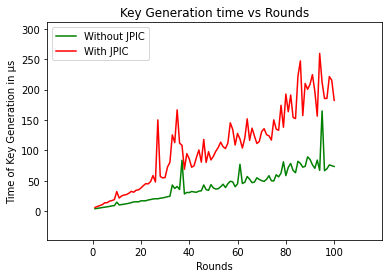

Trendline:: [0.8200495  1.20433638] 
 [2.013645   5.48331649]


<Figure size 432x288 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt 
s = DBCursor.execute('SELECT counter, time_in_secs FROM key_maker WHERE jpic = ?' , (False , ) ).fetchall()
x , y = zip(*s)
y = np.array(y)*(10**6)
plt.plot(x, y , color = 'g' , label = 'Without JPIC')
plt.margins(0.2)
p1 = np.polyfit(x, y, 1)

s = DBCursor.execute('SELECT counter, time_in_secs FROM key_maker WHERE jpic = ?' , (True , ) ).fetchall()
x , y = zip(*s)
y = np.array(y)*(10**6)
plt.plot(x, y , color = 'r' , label = 'With JPIC')
plt.margins(0.2)
p2 = np.polyfit(x, y, 1)



plt.title('Key Generation time vs Rounds')
plt.xlabel('Rounds')
plt.ylabel('Time of Key Generation in µs')
plt.legend()
plt.show()
print('Trendline::' , p1  , '\n', p2 )
plt.savefig('images/keygen.png')

No handles with labels found to put in legend.


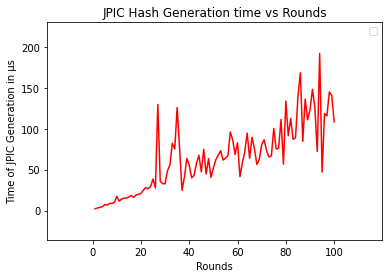

Trendline:: [1.1935955  4.27898011]


<Figure size 432x288 with 0 Axes>

In [19]:
s = DBCursor.execute('SELECT counter, time_in_secs FROM jpic_maker'  ).fetchall()
x , y = zip(*s)

y = np.array(y)*(10**6)
plt.plot(x, y , color = 'r')
plt.margins(0.2)
p2 = np.polyfit(x, y, 1)


plt.title('JPIC Hash Generation time vs Rounds')
plt.xlabel('Rounds')
plt.ylabel('Time of JPIC Generation in µs')
plt.legend()
plt.show()
print('Trendline::' , p2 )
plt.savefig('images/jpic.png')

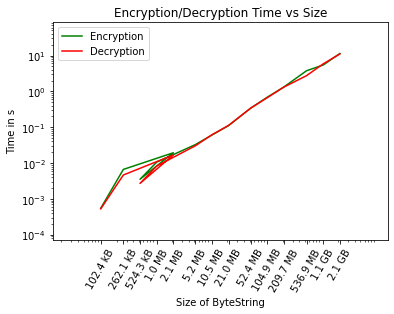

Trendline:: [5.29474076e-09 8.20558520e-02] 
 [5.19016289e-09 4.42716702e-02]


<Figure size 432x288 with 0 Axes>

In [14]:
##enc b2b time and dec b2b time 

import matplotlib.pyplot as plt
import humanize
s = DBCursor.execute('SELECT size, time_in_secs FROM enc_b2b_size'  ).fetchall()
x , y = zip(*s)
y = np.array(y)
plt.plot(x, y , color = 'g' , label = 'Encryption')
plt.margins(0.2)
p1 = np.polyfit(x, y, 1)

s = DBCursor.execute('SELECT size, time_in_secs FROM dec_b2b_size'  ).fetchall()
x , y = zip(*s)
y = np.array(y)
plt.plot(x, y , color = 'r' , label = 'Decryption')
plt.margins(0.2)
p2 = np.polyfit(x, y, 1)



plt.title('Encryption/Decryption Time vs Size')
plt.xlabel('Size of ByteString')
plt.ylabel('Time in s')
plt.xscale('log')
plt.yscale('log')
plt.xticks(x , list(map(humanize.naturalsize , x)) , rotation = '60')
plt.legend()

plt.show()
print('Trendline::' , p1  , '\n', p2 )
plt.savefig('images/b2b.png')

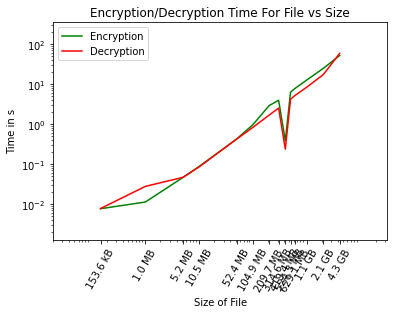

Trendline:: [ 1.20134917e-08 -4.06319735e-01] 
 [ 1.27245674e-08 -1.81193903e+00]


<Figure size 432x288 with 0 Axes>

In [15]:
##enc b2b time and dec b2b time 

import matplotlib.pyplot as plt
import humanize
s = DBCursor.execute('SELECT size, time_in_secs FROM enc_f2f'  ).fetchall()
x , y = zip(*s)
y = np.array(y)
plt.plot(x, y , color = 'g' , label = 'Encryption')
plt.margins(0.2)
p1 = np.polyfit(x, y, 1)

s = DBCursor.execute('SELECT size, time_in_secs FROM dec_f2f'  ).fetchall()
x , y = zip(*s)
y = np.array(y)
plt.plot(x, y , color = 'r' , label = 'Decryption')
plt.margins(0.2)
p2 = np.polyfit(x, y, 1)



plt.title('Encryption/Decryption Time For File vs Size')
plt.xlabel('Size of File')
plt.ylabel('Time in s')
plt.xscale('log')
plt.yscale('log')
plt.xticks(x , list(map(humanize.naturalsize , x)) , rotation = '60')
plt.legend()
plt.show()
print('Trendline::' , p1  , '\n', p2 )
plt.savefig('images/f2f.png')

No handles with labels found to put in legend.


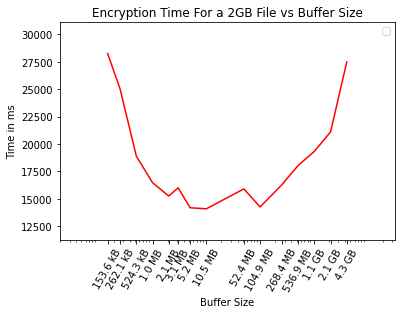

Trendline:: [-3.86444435e-25  2.72100874e-15 -2.33367012e-06  1.79005480e+04]


<Figure size 432x288 with 0 Axes>

In [16]:
s = DBCursor.execute('SELECT size, time_in_secs FROM buffertests'  ).fetchall()
x , y = zip(*s)

y = np.array(y)*(10**3)
plt.plot(x, y , color = 'r')
plt.margins(0.2)
p2 = np.polyfit(x, y, 3)


plt.title('Encryption Time For a 2GB File vs Buffer Size')
plt.xlabel('Buffer Size')
plt.ylabel('Time in ms')
plt.xscale('log')
plt.xticks(x , list(map(humanize.naturalsize , x)) , rotation = '60')
plt.legend()
plt.show()
print('Trendline::' , p2 )
plt.savefig('images/buffers.png')

In [18]:
!zip -r images.zip images

updating: images/ (stored 0%)
  adding: images/.ipynb_checkpoints/ (stored 0%)
  adding: images/jpic.png (deflated 83%)
  adding: images/buffers.png (deflated 83%)
  adding: images/b2b.png (deflated 83%)
  adding: images/keygen.png (deflated 83%)
  adding: images/f2f.png (deflated 83%)
